# Inception Model Building Pipeline for 1D Signals with DEMO
#### Inception_v3, Inception_v4

# Test GPU (Optional)
Before Starting, kindly check the available GPU from the Google Server, GPU model and other related information. It might help!

In [1]:
import torch
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))
print("Is GPU Initialized yet?", torch.cuda.is_initialized())

Is CUDA enabled GPU Available? True
GPU Number: 1
Current GPU Index: 0
GPU Type: Tesla P100-PCIE-16GB
GPU Capability: (6, 0)
Is GPU Initialized yet? True


# Connect to Google Drive (Optional for Google COLAB)

Copy-Paste the Authorization Code and Mount Google Drive to COLAB

In [ ]:
from google.colab import drive
drive.mount('/content/GDrive')

Move to the Target Directory

In [ ]:
%cd /content

List the Files and Folders Located in the Current Directory

In [ ]:
!ls

Upload Files from Local Directory (if required)

In [ ]:
from google.colab import files
uploaded = files.upload()

#Import Necessary Libraries

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import interp
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, roc_curve, plot_roc_curve
from sklearn.metrics import confusion_matrix, classification_report, auc, precision_recall_curve, average_precision_score
sns.set_theme(style="whitegrid")

In [60]:
# Import Inception Module
from Inception_1DCNN import Inception
from Inception_ResNet_1DCNN import Inception_ResNet

# DEMO: Regression and Classification


## Regression

### Import and Prepare Dataset

Import Dataset from a CSV file using Pandas. This DEMO uses the Weather History dataset from Kaggle.  
Source: https://www.kaggle.com/budincsevity/szeged-weather

In [40]:
dataset = pd.read_csv('WeatherHistory.csv')
print(dataset.shape)
dataset.head(5)

(96453, 11)


,Formatted Date,Summary,Precip Type,Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Temperature (C),Apparent Temperature (C)
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,0.89,14.1197,251,15.8263,1015.13,Partly cloudy throughout the day.,9.472222,7.388889
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,0.86,14.2646,259,15.8263,1015.63,Partly cloudy throughout the day.,9.355556,7.227778
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,0.89,3.9284,204,14.9569,1015.94,Partly cloudy throughout the day.,9.377778,9.377778
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,0.83,14.1036,269,15.8263,1016.41,Partly cloudy throughout the day.,8.288889,5.944444
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,0.83,11.0446,259,15.8263,1016.51,Partly cloudy throughout the day.,8.755556,6.977778


Have a look at the dataset! The CSV file includes a hourly/daily summary for Szeged, Hungary area, between 2006 and 2016.

Data available in the hourly response:

1. Time  
2. Summary  
3. PrecipType  
4. Temperature  
5. ApparentTemperature  
6. Humidity  
7. WindSpeed  
8. WindBearing  
9. Visibility  
10. LoudCover  
11. Pressure  

Check for any existing 'NaN' value in the dataset which might create issues afterwards. We, here, check both overall and column by column.

In [41]:
print(f'Total NULL values in the Original DataFrame = {dataset.isnull().sum().sum()}')
print(dataset.isnull().sum())

Total NULL values in the Original DataFrame = 517
Formatted Date                0
Summary                       0
Precip Type                 517
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Pressure (millibars)          0
Daily Summary                 0
Temperature (C)               0
Apparent Temperature (C)      0
dtype: int64


There are total 517 NULL or NaN values and all of them are in the 'Precip_Type' Column. Let's print out the unique values in that column.

In [43]:
dataset['Precip Type'].unique()

array(['rain', 'snow', nan], dtype=object)

So, it can be seen that there are mainly 2 classes in this column other than the NaN. So, we can replace the NaN cell with 'Unknown' instead of '0' (which is done more commonly).

In [44]:
dataset['Precip Type'] = dataset['Precip Type'].fillna('Unknown')

One important realization is that we could easily remove those rows in this case instead of filling up the NULLs, but that would remove some datapoints. For very large datasets, it might not matter. On the contrary, sometimes it might remove important observations. If the dataset is too sparse, then it is better to remove the rows instead of filling. But since in this case, value in only 1 column was missing, it was filled up with a suitable replacement.

In [45]:
dataset['Precip Type'].unique()

array(['rain', 'snow', 'Unknown'], dtype=object)

Now, at first slice the DataTime Frame into month and hour since they can be strong indicators of weather (fairly long term and short term). Years can also show gradual change in weather pattern (especially change in the climate) but that has been ignored in this study. Modify it according to your wish to improve performance.

In [46]:
dataset['Month'] = (dataset['Formatted Date']).str.slice(start=5, stop=7)
dataset['Hour'] = (dataset['Formatted Date']).str.slice(start=11, stop=13)
dataset.head(5)

,Formatted Date,Summary,Precip Type,Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Temperature (C),Apparent Temperature (C),Month,Hour
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,0.89,14.1197,251,15.8263,1015.13,Partly cloudy throughout the day.,9.472222,7.388889,04,00
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,0.86,14.2646,259,15.8263,1015.63,Partly cloudy throughout the day.,9.355556,7.227778,04,01
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,0.89,3.9284,204,14.9569,1015.94,Partly cloudy throughout the day.,9.377778,9.377778,04,02
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,0.83,14.1036,269,15.8263,1016.41,Partly cloudy throughout the day.,8.288889,5.944444,04,03
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,0.83,11.0446,259,15.8263,1016.51,Partly cloudy throughout the day.,8.755556,6.977778,04,04


The first DateTime Frame column and the column containing the real temperature for that hour have been dropped. The aim here is to predict "Apparent Temperature" from other weather indicators using Deep Learning based Regression.

In [47]:
dataset.drop(['Formatted Date', 'Temperature (C)'], axis=1, inplace=True)
dataset.head(5)

,Summary,Precip Type,Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Apparent Temperature (C),Month,Hour
0,Partly Cloudy,rain,0.89,14.1197,251,15.8263,1015.13,Partly cloudy throughout the day.,7.388889,04,00
1,Partly Cloudy,rain,0.86,14.2646,259,15.8263,1015.63,Partly cloudy throughout the day.,7.227778,04,01
2,Mostly Cloudy,rain,0.89,3.9284,204,14.9569,1015.94,Partly cloudy throughout the day.,9.377778,04,02
3,Partly Cloudy,rain,0.83,14.1036,269,15.8263,1016.41,Partly cloudy throughout the day.,5.944444,04,03
4,Mostly Cloudy,rain,0.83,11.0446,259,15.8263,1016.51,Partly cloudy throughout the day.,6.977778,04,04


Rearrange the Columns, place the target column at the end for next step

In [48]:
dataset = dataset[['Month', 'Hour', 'Summary', 'Precip Type', 'Humidity', 
                   'Wind Speed (km/h)', 'Wind Bearing (degrees)', 
                   'Visibility (km)', 'Pressure (millibars)', 'Daily Summary', 
                   'Apparent Temperature (C)']]
dataset.head(5)

,Month,Hour,Summary,Precip Type,Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Apparent Temperature (C)
0,04,00,Partly Cloudy,rain,0.89,14.1197,251,15.8263,1015.13,Partly cloudy throughout the day.,7.388889
1,04,01,Partly Cloudy,rain,0.86,14.2646,259,15.8263,1015.63,Partly cloudy throughout the day.,7.227778
2,04,02,Mostly Cloudy,rain,0.89,3.9284,204,14.9569,1015.94,Partly cloudy throughout the day.,9.377778
3,04,03,Partly Cloudy,rain,0.83,14.1036,269,15.8263,1016.41,Partly cloudy throughout the day.,5.944444
4,04,04,Mostly Cloudy,rain,0.83,11.0446,259,15.8263,1016.51,Partly cloudy throughout the day.,6.977778


At this stage, check the datatypes of the columns. You can see that 'Month' and 'Hour' columns are object types, convert them to numeric 'int64' (otherwise while creating dummy variables, each month or hour will get a separate column, which is unncessary). 

In [49]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Month                     96453 non-null  object 
 1   Hour                      96453 non-null  object 
 2   Summary                   96453 non-null  object 
 3   Precip Type               96453 non-null  object 
 4   Humidity                  96453 non-null  float64
 5   Wind Speed (km/h)         96453 non-null  float64
 6   Wind Bearing (degrees)    96453 non-null  int64  
 7   Visibility (km)           96453 non-null  float64
 8   Pressure (millibars)      96453 non-null  float64
 9   Daily Summary             96453 non-null  object 
 10  Apparent Temperature (C)  96453 non-null  float64
dtypes: float64(5), int64(1), object(5)
memory usage: 8.1+ MB


In [50]:
dataset['Month'] = dataset['Month'].astype('int64')
dataset['Hour'] = dataset['Hour'].astype('int64')

In [51]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Month                     96453 non-null  int64  
 1   Hour                      96453 non-null  int64  
 2   Summary                   96453 non-null  object 
 3   Precip Type               96453 non-null  object 
 4   Humidity                  96453 non-null  float64
 5   Wind Speed (km/h)         96453 non-null  float64
 6   Wind Bearing (degrees)    96453 non-null  int64  
 7   Visibility (km)           96453 non-null  float64
 8   Pressure (millibars)      96453 non-null  float64
 9   Daily Summary             96453 non-null  object 
 10  Apparent Temperature (C)  96453 non-null  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 8.1+ MB


Convert Text Data into Dummy Variables for Machine Learning.  
It is important since Machine Learning models will not accept non-numerical data directly during training or testing.

In [52]:
dummy_dataset = pd.DataFrame()

In [53]:
for i in range(0,len(dataset.columns)):
  X = dataset[dataset.columns[i]]
  if type(X[0]) == str:
    Y = pd.get_dummies(X)
    dummy_dataset = pd.concat([dummy_dataset, Y], axis=1)
  else:
    dummy_dataset = pd.concat([dummy_dataset, X], axis=1)
#
dummy_dataset.shape

(96453, 252)

In [54]:
dummy_dataset.head(5)

,Month,Hour,Breezy,Breezy and Dry,Breezy and Foggy,Breezy and Mostly Cloudy,Breezy and Overcast,Breezy and Partly Cloudy,Clear,Dangerously Windy and Partly Cloudy,Drizzle,Dry,Dry and Mostly Cloudy,Dry and Partly Cloudy,Foggy,Humid and Mostly Cloudy,Humid and Overcast,Humid and Partly Cloudy,Light Rain,Mostly Cloudy,Overcast,Partly Cloudy,Rain,Windy,Windy and Dry,Windy and Foggy,Windy and Mostly Cloudy,Windy and Overcast,Windy and Partly Cloudy,Unknown,rain,snow,Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Breezy and foggy starting in the evening.,Breezy and foggy until morning.,Breezy and mostly cloudy overnight.,...,Partly cloudy starting overnight continuing until afternoon.,Partly cloudy starting overnight continuing until evening and breezy in the evening.,Partly cloudy starting overnight continuing until evening and breezy in the morning.,Partly cloudy starting overnight continuing until evening and breezy starting in the morning continuing until afternoon.,Partly cloudy starting overnight continuing until evening and breezy starting in the morning continuing until evening.,Partly cloudy starting overnight continuing until evening and windy starting in the morning continuing until evening.,Partly cloudy starting overnight continuing until evening.,Partly cloudy starting overnight continuing until morning and breezy starting in the morning continuing until afternoon.,Partly cloudy starting overnight continuing until morning.,Partly cloudy starting overnight continuing until night and breezy in the afternoon.,Partly cloudy starting overnight continuing until night and breezy in the morning.,Partly cloudy starting overnight continuing until night and windy starting in the morning continuing until afternoon.,Partly cloudy starting overnight continuing until night.,Partly cloudy starting overnight.,Partly cloudy throughout the day and breezy in the afternoon.,Partly cloudy throughout the day and breezy in the evening.,Partly cloudy throughout the day and breezy in the morning.,Partly cloudy throughout the day and breezy starting in the afternoon continuing until evening.,Partly cloudy throughout the day and breezy starting in the morning continuing until afternoon.,Partly cloudy throughout the day and breezy starting in the morning continuing until evening.,Partly cloudy throughout the day and breezy starting in the morning continuing until night.,Partly cloudy throughout the day and windy starting in the morning continuing until afternoon.,Partly cloudy throughout the day.,Partly cloudy until afternoon.,Partly cloudy until evening and breezy in the afternoon.,Partly cloudy until evening and breezy in the morning.,Partly cloudy until evening and breezy overnight.,Partly cloudy until evening and breezy starting in the morning continuing until afternoon.,Partly cloudy until evening and breezy starting in the morning continuing until evening.,Partly cloudy until evening.,Partly cloudy until morning.,Partly cloudy until night and breezy in the afternoon.,Partly cloudy until night and breezy in the morning.,Partly cloudy until night and breezy starting in the morning continuing until afternoon.,Partly cloudy until night.,Rain throughout the day.,Rain until afternoon.,Rain until morning.,Windy in the afternoon.,Apparent Temperature (C)
0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.89,14.1197,251,15.8263,1015.13,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.388889
1,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.86,14.2646,259,15.8263,1015.63,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.227778
2,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0.89,3.9284,204,14.9569,1015.94,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.377778
3,4,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.83,14.1036,26

At this stage, you can plot the dataset prior to check any pattern in the dataset or just for illustrative purposes.

Convert Pandas DataFrame into NumPy Arrays

In [55]:
X_Data = dummy_dataset.iloc[:,0:-1].values # All columns except the last are the predicting variables
Y_Data = dummy_dataset.iloc[:,-1].values # Last column (Weight Column in this case) is the label
print(X_Data.shape)
print(Y_Data.shape)

(96453, 251)
(96453,)


Train-Test Split

In [56]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_Data, Y_Data, test_size=0.20, random_state=42)

The third axis is to show the number of channels, which is 1 in this case. If same labels were appropriate for more than 1 dataset, there would be more than 1 channel.

In [57]:
X_Train = np.expand_dims(X_Train, axis=2)
X_Test = np.expand_dims(X_Test, axis=2)

In [58]:
print(X_Train.shape, X_Test.shape)
print(Y_Train.shape, Y_Test.shape)

(77162, 251, 1) (19291, 251, 1)
(77162,) (19291,)


### Build and Train Imported Data using the Inception based Regression Model

Configurations - Select the Configurations for the Inception Model. Vary them (while following the guidelines) to improve performance.

In [25]:
"Configurations for Inception in Regression Mode"
length = X_Train.shape[1]   # Number of Features (or length of the signal)
model_width = 32            # Number of Filter or Kernel in the Input Layer (Power of 2 to avoid error)
num_channel = 1             # Number of Input Channels
problem_type = 'Regression' # Regression or Classification
output_number = 1           # Number of Outputs in the Regression Mode - 1 input is mapped to a single output

Build Model

In [26]:
Regression_Model = Inception(length, num_channel, model_width, problem_type=problem_type, output_nums=output_number).Inception_v3() # Build Model
# Inception Models supported: Inception_v3, Inception_v4, Inception_ResNet_v1, Inception_ResNet_v2
Regression_Model.compile(loss='mae', optimizer='adam', metrics= ['mse']) # Compile Model
# Here, Model validation metric is set as Mean Squared Error or MSE

Model_Summary

In [27]:
Regression_Model.summary() # Summary of the Model

Model: "Inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 124, 32)      128         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 124, 32)      128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 124, 32)      0           batch_normalization[0][0]        
_______________________________________________________________________________________

Upload Past Weights if available

In [28]:
Regression_Model.load_weights('Saved_Model.h5') # Load Previously Trained Weights for Transfer Learning

Train Model for 'n' number of Epochs with Batch size of 'm'

In [92]:
# Early Stopping and Model_Checkpoints are optional parameters
# Early Stopping is to stop the training based on certain condition set by the user
# Model Checkpoint is to save a model in a directory based on certain conditions so that it can be used later for Transfer Learning or avoiding retraining
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, mode='min'), tf.keras.callbacks.ModelCheckpoint('Saved_Model.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
history = Regression_Model.fit(X_Train, Y_Train, epochs=500, batch_size=128, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks)
# Save 'History' of the model for model performance analysis performed later

Epoch 1/500
483/483 [==============================] - 101s 128ms/step - loss: 5.1322 - mse: 47.0123 - val_loss: 13.0145 - val_mse: 219.9412

Epoch 00001: val_loss improved from inf to 13.01449, saving model to Saved_Model.h5
Epoch 2/500
483/483 [==============================] - 58s 121ms/step - loss: 3.2454 - mse: 17.3130 - val_loss: 4.4219 - val_mse: 31.3278

Epoch 00002: val_loss improved from 13.01449 to 4.42193, saving model to Saved_Model.h5
Epoch 3/500
483/483 [==============================] - 58s 121ms/step - loss: 3.1344 - mse: 16.1457 - val_loss: 3.6010 - val_mse: 20.8093

Epoch 00003: val_loss improved from 4.42193 to 3.60100, saving model to Saved_Model.h5
Epoch 4/500
483/483 [==============================] - 58s 120ms/step - loss: 3.1007 - mse: 15.8384 - val_loss: 3.6685 - val_mse: 21.1552

Epoch 00004: val_loss did not improve from 3.60100
Epoch 5/500
483/483 [==============================] - 58s 120ms/step - loss: 3.0709 - mse: 15.5617 - val_loss: 3.3461 - val_mse: 1

Test and Predict

In [93]:
# Preictions from the Test Set from the Trained Model
Predictions = Regression_Model.predict(X_Test, verbose=1)
print(Predictions.shape)

603/603 [==============================] - 14s 20ms/step
(19291, 1)


Error Performance (Mean Sqaured Error or MAE)

In [94]:
# Error of the prediction, one of many evaluation metrics
# Using Mean Absolute Error (MAE) in this case as a sample
Error = mean_absolute_error(Y_Test, Predictions)
print(f"MAE: {Error}")

MAE: 1.8259369977261823


Plot Train and Validation Error and Loss

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


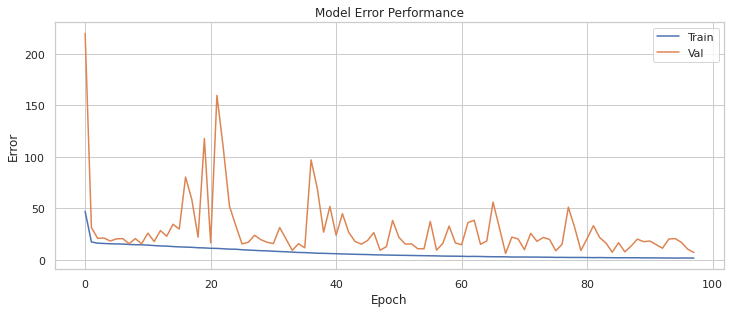

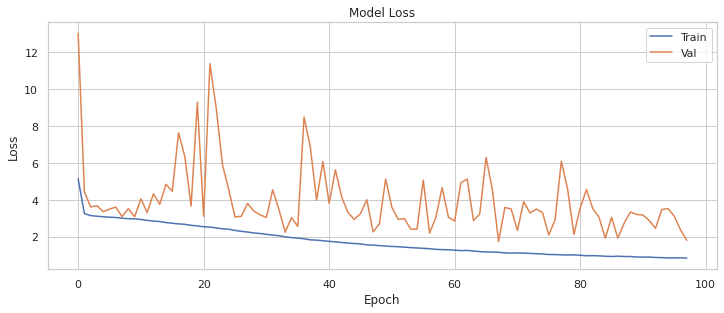

In [95]:
def history_plot(history):
  # list all dictionaries in history
  print(history.history.keys())
  # summarize history for error
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,1)
  plt.plot(history.history['mse'])
  plt.plot(history.history['val_mse'])
  plt.title('Model Error Performance')
  plt.ylabel('Error')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
  # summarize history for loss
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
#
history_plot(history)

Plot Prediction Performance

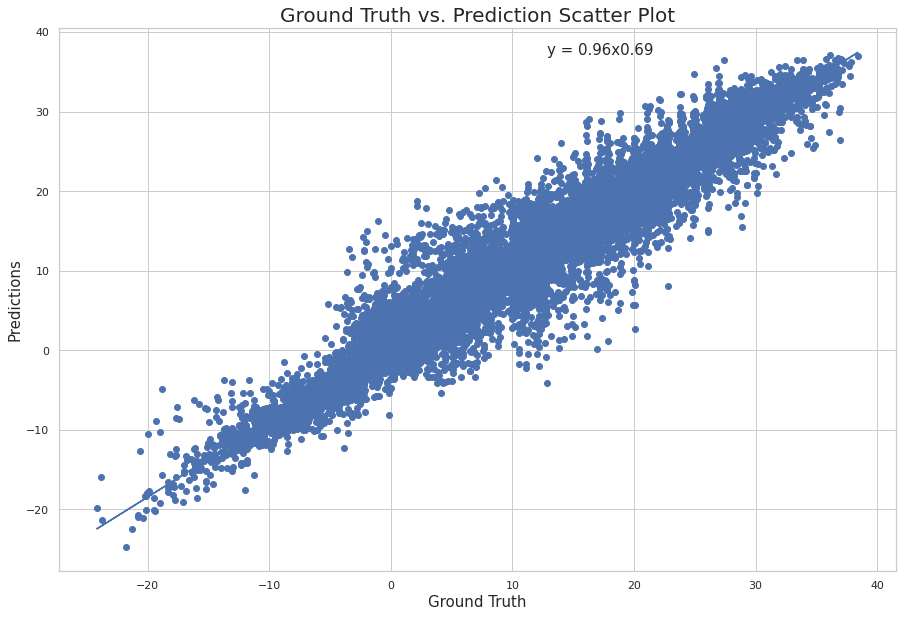

In [96]:
def plot_prediction(test_labels, test_predictions):
  plt.figure(figsize=(15,10))
  plt.scatter(test_labels, test_predictions)
  '''Add Trendline'''
  z = np.polyfit(test_labels.ravel(), test_predictions.ravel(), 1)
  p = np.poly1d(z)
  plt.plot(test_labels, p(test_labels))
  plt.text(np.max(test_labels)/3,np.max(test_predictions),f'y = {p[1]:.2f}x+{p[0]:.2f}', fontsize=15)
  plt.title('Ground Truth vs. Prediction Scatter Plot', fontsize=20)
  plt.xlabel('Ground Truth', fontsize=15)
  plt.ylabel('Predictions', fontsize=15)
#
plot_prediction(Y_Test, Predictions)

Kernel Density Plot

Text(0, 0.5, 'Density')

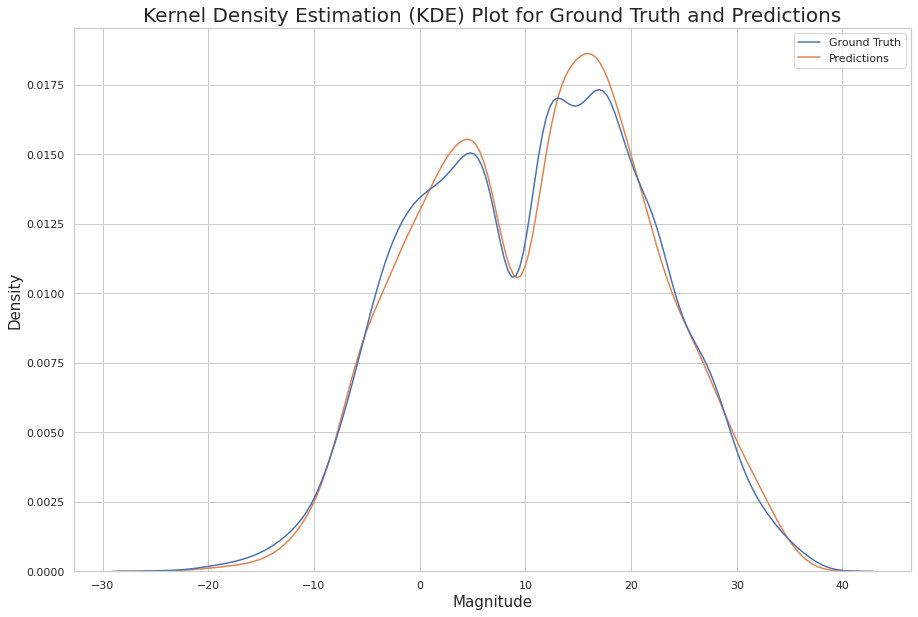

In [97]:
df = pd.DataFrame(data = {'Ground Truth': Y_Test.ravel(), 'Predictions': Predictions.ravel()})
plt.figure(figsize=(15,10))
sns.set_style('whitegrid')
sns.kdeplot(data=df)
plt.title('Kernel Density Estimation (KDE) Plot for Ground Truth and Predictions', fontsize=20)
plt.xlabel('Magnitude', fontsize=15)
plt.ylabel('Density', fontsize=15)

Text(0, 0.5, 'Magnitude')

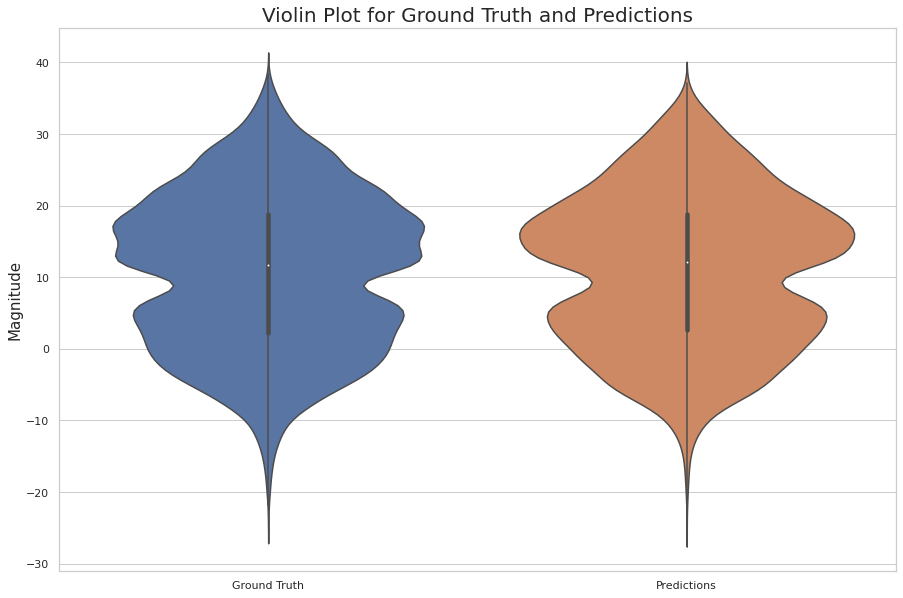

In [98]:
plt.figure(figsize = (15,10))
df = pd.DataFrame(data = {'Ground Truth': Y_Test.ravel(), 'Predictions': Predictions.ravel()})
ax = sns.violinplot(data=df)
plt.title('Violin Plot for Ground Truth and Predictions', fontsize=20)
plt.ylabel('Magnitude', fontsize=15)

Both from the Kernel Density Plot or the Violin Plot, it can be seen that not only the MAE is good, but also the predicted values follow the same pattern as the ground truth, which proves the robustness of the model.

## Classification

### Data Preparation

Import the dataset from a CSV file and save it into a Pandas DataFrame

In [29]:
dataset = pd.read_excel('Drug_Persistency.xlsx', sheet_name = 'Dataset')
dataset.drop(columns=['Ptid'], inplace=True) # Drop Patient ID Column
print(dataset.shape)
dataset.head(10)

(3424, 68)


,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Dexa_Freq_During_Rx,Dexa_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Risk_Segment_Prior_Ntm,Tscore_Bucket_Prior_Ntm,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Change_T_Score,Change_Risk_Segment,Adherent_Flag,Idn_Indicator,Injectable_Experience_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias,Comorb_Osteoporosis_without_current_pathological_fracture,Comorb_Personal_history_of_malignant_neoplasm,Comorb_Gastro_esophageal_reflux_disease,Concom_Cholesterol_And_Triglyceride_Regulating_Preparations,Concom_Narcotics,Concom_Systemic_Corticosteroids_Plain,Concom_Anti_Depressants_And_Mood_Stabilisers,Concom_Fluoroquinolones,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Broad_Spectrum_Penicillins,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Risk_Type_1_Insulin_Dependent_Diabetes,Risk_Osteogenesis_Imperfecta,Risk_Rheumatoid_Arthritis,Risk_Untreated_Chronic_Hyperthyroidism,Risk_Untreated_Chronic_Hypogonadism,Risk_Untreated_Early_Menopause,Risk_Patient_Parent_Fractured_Their_Hip,Risk_Smoking_Tobacco,Risk_Chronic_Malnutrition_Or_Malabsorption,Risk_Chronic_Liver_Disease,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks
0,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,VLR_LR,<=-2.5,No change,Unknown,Adherent,N,Y,N,Y,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0
1,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0
2,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,HR_VHR,<=-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,Y,N,Y,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,Y,N,N,N,N,N,N,N,2
3,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,Y,0,N,N,N,HR_VHR,>-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,N,Y,Y,N,Y,N,N,Y,N,N,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1
4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,Y,Y,0,N,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,Y,Y,Y,N,N,N,N,Y,Y,N,N,N,N,N,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1
5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,Y,N,N,N,N,N,N,N,N,2
6,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,2,Y,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,N,N,Y,Y,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,Y,N,N,Y,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,1
7,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/

Create a Blank DataFrame

In [30]:
dummy_dataset = pd.DataFrame()

In [31]:
for i in range(0,len(dataset.columns)):
  X = dataset[dataset.columns[i]]
  if type(X[0]) == str:
    Y = pd.get_dummies(X)
    dummy_dataset = pd.concat([dummy_dataset, Y], axis=1)
  else:
    dummy_dataset = pd.concat([dummy_dataset, X], axis=1)
#
dummy_dataset.head(10)

,Non-Persistent,Persistent,Female,Male,African American,Asian,Caucasian,Other/Unknown,Hispanic,Not Hispanic,Unknown,Midwest,Northeast,Other/Unknown,South,West,55-65,65-75,<55,>75,CARDIOLOGY,CLINICAL NURSE SPECIALIST,EMERGENCY MEDICINE,ENDOCRINOLOGY,GASTROENTEROLOGY,GENERAL PRACTITIONER,GERIATRIC MEDICINE,HEMATOLOGY & ONCOLOGY,HOSPICE AND PALLIATIVE MEDICINE,HOSPITAL MEDICINE,NEPHROLOGY,NEUROLOGY,NUCLEAR MEDICINE,OBSTETRICS & OBSTETRICS & GYNECOLOGY & OBSTETRICS & GYNECOLOGY,OBSTETRICS AND GYNECOLOGY,OCCUPATIONAL MEDICINE,ONCOLOGY,OPHTHALMOLOGY,ORTHOPEDIC SURGERY,ORTHOPEDICS,...,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,Count_Of_Risks
0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0
1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0
2,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,2
3,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
4,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
5,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,2
6,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
7,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
8,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
9,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1


Convert the DataFrame to a Numpy Array

In [32]:
X_Data = dummy_dataset.iloc[:,0:-1].values
Y_Data = dummy_dataset.iloc[:,-1].values
print(X_Data.shape)
print(Y_Data.shape)

(3424, 182)
(3424,)


Get Unique Labels

In [33]:
'''Print out the Classes to track the sequence, will be important in the evaluation section (e.g., Labelling Conf Mat)'''
L_E = LabelEncoder()
L_E.fit_transform(Y_Data)
labels = L_E.classes_
print(f'Classes: {labels}')

Classes: [0 1 2 3 4 5 6 7]


Train_Test Split

In [34]:
X_Train, X_Test, Y_Train_, Y_Test_ = train_test_split(X_Data, Y_Data, test_size=0.20, random_state=42)

One-Hot-Encoding for the Classification Labels

In [35]:
def one_hot_encoding(data):
  L_E = LabelEncoder()
  integer_encoded = L_E.fit_transform(data)  
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  one_hot_encoded_data = onehot_encoder.fit_transform(integer_encoded)
  return one_hot_encoded_data

In [36]:
Y_Train = one_hot_encoding(Y_Train_.ravel())
Y_Test = one_hot_encoding(Y_Test_.ravel())

Train and Test Data Shapes

In [37]:
print(X_Train.shape, X_Test.shape)
print(Y_Train.shape, Y_Test.shape)

(2739, 182) (685, 182)
(2739, 8) (685, 8)


### Build and Train Imported Data using the Inception based Classification Model

Configurations

In [ ]:
"Configurations for the 1D Network in Classification Mode"
length = X_Train.shape[1]       # Number of Features (or length of the signal)
model_width = 64                # Number of Filter or Kernels in the Input Layer (Power of 2 to avoid error)
num_channel = 1                 # Number of Input Channels
problem_type = 'Classification' # Regression or Classification
class_number = Y_Train.shape[1] # Number of Output Class in Classification Mode (>=2)

Build Model

In [ ]:
Classification_Model = Inception(length, num_channel, model_width, problem_type=problem_type, output_nums=class_number).Inception_v4()
if class_number == 2:
  Classification_Model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mse','accuracy'])
elif class_number > 2:
  Classification_Model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mse','accuracy'])

Model Summary

In [ ]:
Classification_Model.summary()

Model: "Inception_v4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 182, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_333 (Conv1D)             (None, 90, 32)       128         input_21[0][0]                   
__________________________________________________________________________________________________
batch_normalization_468 (BatchN (None, 90, 32)       128         conv1d_333[0][0]                 
__________________________________________________________________________________________________
activation_159 (Activation)     (None, 90, 32)       0           batch_normalization_468[0][0]    
_______________________________________________________________________________________

Upload Past Weights (Transfer Learning)

In [ ]:
Classification_Model.load_weights('Saved_Model.h5') # Load Previously Trained Weights for Transfer Learning

Train Model

In [ ]:
# Early Stopping and Model_Checkpoints are optional parameters
# Early Stopping is to stop the training based on certain condition set by the user
# Model Checkpoint is to save a model in a directory based on certain conditions so that it can be used later for Transfer Learning or avoiding retraining
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, mode='min'), 
             tf.keras.callbacks.ModelCheckpoint('Saved_Model.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
history = Classification_Model.fit(X_Train, Y_Train, epochs=300, batch_size=128, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks)

Epoch 1/300
18/18 [==============================] - 12s 135ms/step - loss: 1.4881 - mse: 0.0903 - accuracy: 0.4003 - val_loss: 1.8541 - val_mse: 0.1022 - val_accuracy: 0.3978

Epoch 00001: val_loss improved from inf to 1.85410, saving model to Saved_Model.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/300
18/18 [==============================] - 1s 42ms/step - loss: 0.5897 - mse: 0.0397 - accuracy: 0.7782 - val_loss: 1.6944 - val_mse: 0.0964 - val_accuracy: 0.3978

Epoch 00002: val_loss improved from 1.85410 to 1.69439, saving model to Saved_Model.h5
Epoch 3/300
18/18 [==============================] - 1s 42ms/step - loss: 0.3373 - mse: 0.0219 - accuracy: 0.8818 - val_loss: 1.6018 - val_mse: 0.0933 - val_accuracy: 0.3978

Epoch 00003: val_loss improved from 1.69439 to 1.60181, saving model to Saved_Model.h5
Epoch 4/300
18/18 [==============================] - 1s 42ms/step - loss: 0.1873 - mse: 0.0130 - accuracy: 0.9256 - val_loss: 1.5566 - val_mse: 0.0923 - val_accuracy: 0.3978

Epoch 00004: val_loss improved from 1.60181 to 1.55658, saving model to Saved_Model.h5
Epoch 5/300
18/18 [==============================] - 1s 41ms/step - loss: 0.1129 - mse: 0.0076 - accuracy: 0.9566 - val_loss: 1.5441 - val_mse: 0.0931 - val_accuracy: 0.3978

Epoch 00005: val_loss improved from 1.5

Test

In [ ]:
# Predictions from the Test Set from the Trained Model
Predictions = Classification_Model.predict(X_Test, verbose=1)
print(Predictions.shape)

22/22 [==============================] - 1s 12ms/step
(685, 8)


Error Performance

In [ ]:
# Error of the prediction, one of many evaluation metrics
# Using Mean Absolute Error (MAE) in this case as a sample
Error = mean_absolute_error(Y_Test, Predictions)
print(f"MAE: {Error}")

MAE: 0.006325497748811344


Plot Training History [Metrics] - Requires to Train the Model

dict_keys(['loss', 'mse', 'accuracy', 'val_loss', 'val_mse', 'val_accuracy'])


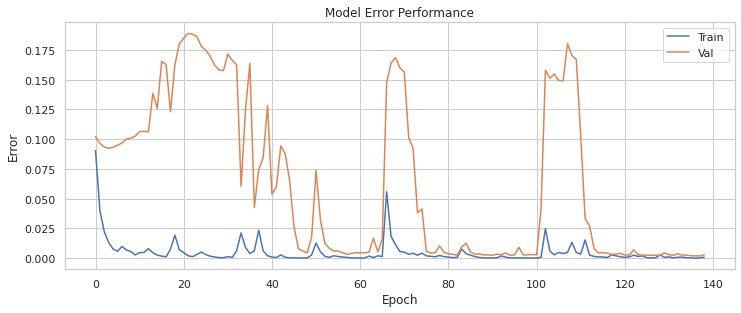

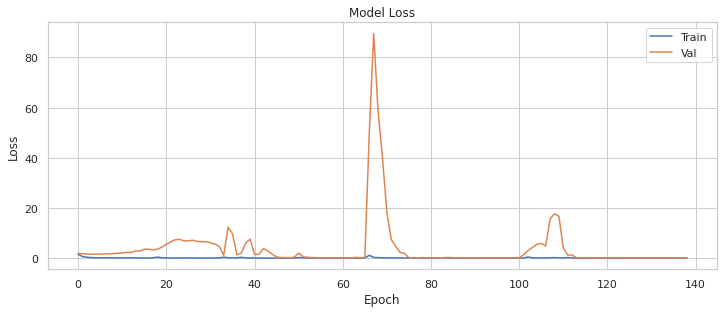

In [ ]:
def history_plot(history):
  # list all dictionaries in history
  print(history.history.keys())
  # summarize history for error
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,1)
  plt.plot(history.history['mse'])
  plt.plot(history.history['val_mse'])
  plt.title('Model Error Performance')
  plt.ylabel('Error')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
  # summarize history for loss
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
#
history_plot(history)

Convert raw predictions into single-column, integer-based predictions

In [ ]:
prediction_shape = Predictions.shape
prediction_length = prediction_shape[0]
Y_Preds = np.zeros((prediction_length, 1), dtype=int)
#
for i in range(0, prediction_length):
  prediction = Predictions[i]
  x = np.where(prediction == np.max(prediction))
  x = int(x[0])
  Y_Preds[i] = x

Y_Preds.shape

(685, 1)

Print Confusion Matrix

In [ ]:
print('-------------------------------------------')
print('Raw Confusion Matrix')
print(confusion_matrix(Y_Test_, Y_Preds, normalize=None))
print('-------------------------------------------')
print('Normalized Confusion Matrix')
print(confusion_matrix(Y_Test_, Y_Preds, normalize='true'))
print('-------------------------------------------')

-------------------------------------------
Raw Confusion Matrix
[[206   0   0   0   0   0   0   0]
 [  0 229   0   0   0   0   0   0]
 [  0   0 154   0   0   0   0   0]
 [  0   0   0  61   0   1   0   0]
 [  0   0   0   7  20   0   1   0]
 [  0   0   0   0   0   2   1   0]
 [  0   0   0   0   0   2   0   0]
 [  0   0   0   0   0   0   1   0]]
-------------------------------------------
Normalized Confusion Matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.98387097 0.         0.01612903
  0.         0.        ]
 [0.         0.         0.         0.25       0.71428571 0.
  0.03571429 0.        ]
 [0.         0.         0.         0.         0.         0.66666667
  0.33333333 0.        ]
 [0.         0.         0.         0.         0.        

Plot Confusion Matrix

In [ ]:
# Use the numeric labels or replace with real-class names. But be careful about their respective sequence
labels = ['Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7']

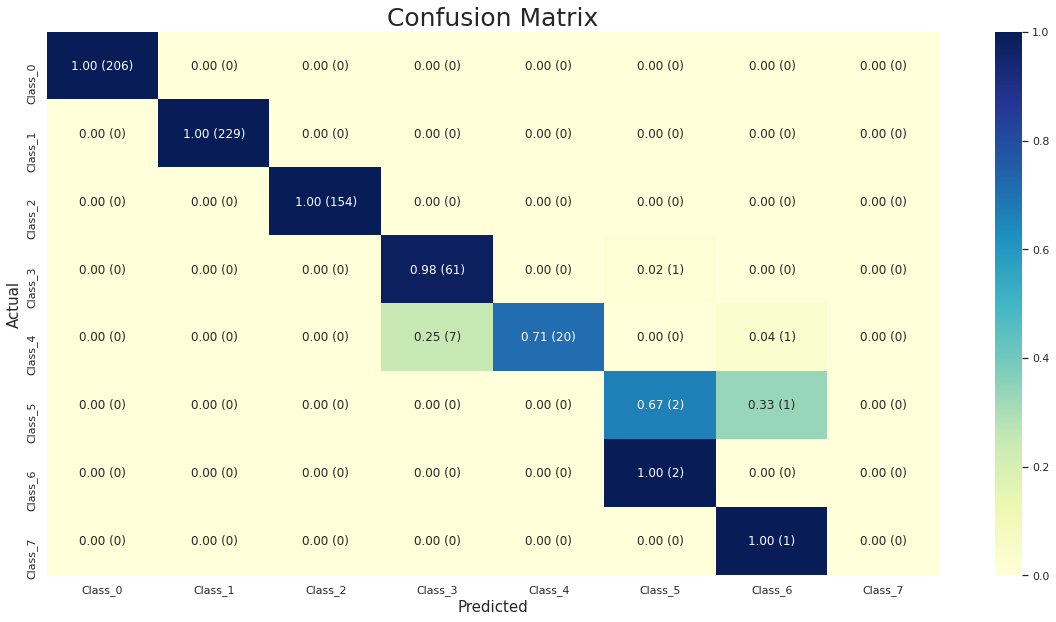

In [ ]:
def plot_conf_mat(Ground_Truth_Labels, Predictions):
  confusion_matrix_raw = confusion_matrix(Ground_Truth_Labels, Predictions, normalize=None)
  confusion_matrix_norm = confusion_matrix(Ground_Truth_Labels, Predictions, normalize='true')
  shape = confusion_matrix_raw.shape
  data = np.asarray(confusion_matrix_raw, dtype=int)
  text = np.asarray(confusion_matrix_norm, dtype=float)
  annots = (np.asarray(["{0:.2f} ({1:.0f})".format(text, data) for text, data in zip(text.flatten(), data.flatten())])).reshape(shape[0],shape[1])
  fig = plt.figure(figsize=(20, 10))
  sns.heatmap(confusion_matrix_norm, cmap='YlGnBu', annot=annots, fmt='', xticklabels=labels, yticklabels=labels)
  plt.title('Confusion Matrix', fontsize=25)
  plt.xlabel("Predicted", fontsize=15)
  plt.ylabel("Actual", fontsize=15)
#
plot_conf_mat(Y_Test_, Y_Preds)

Here it can be seen that risk level 6 and 7 could not be predicted well due to less number of instances.

In [ ]:
# Evaluating Overall Metrics - Accuracy, Precision, Recall, f1-Score
Accuracy = accuracy_score(Y_Test_, Y_Preds)
Precision = precision_score(Y_Test_, Y_Preds, average= 'weighted')
Recall = recall_score(Y_Test_, Y_Preds, average= 'weighted')
f1_Score = f1_score(Y_Test_, Y_Preds, average= 'weighted')
print(f'Accuracy = {Accuracy:.3f}')
print(f'Precision = {Precision:.3f}')
print(f'Recall = {Recall:.3f}')
print(f'f1-Score = {f1_Score:.3f}')

Accuracy = 0.981
Precision = 0.984
Recall = 0.981
f1-Score = 0.981


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(Y_Test_, Y_Preds, target_names=labels, zero_division=0))

              precision    recall  f1-score   support

     Class_0       1.00      1.00      1.00       206
     Class_1       1.00      1.00      1.00       229
     Class_2       1.00      1.00      1.00       154
     Class_3       0.90      0.98      0.94        62
     Class_4       1.00      0.71      0.83        28
     Class_5       0.40      0.67      0.50         3
     Class_6       0.00      0.00      0.00         2
     Class_7       0.00      0.00      0.00         1

    accuracy                           0.98       685
   macro avg       0.66      0.67      0.66       685
weighted avg       0.98      0.98      0.98       685



Multiclass Receiver Operating Characteristic(ROC) Curves Plot

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


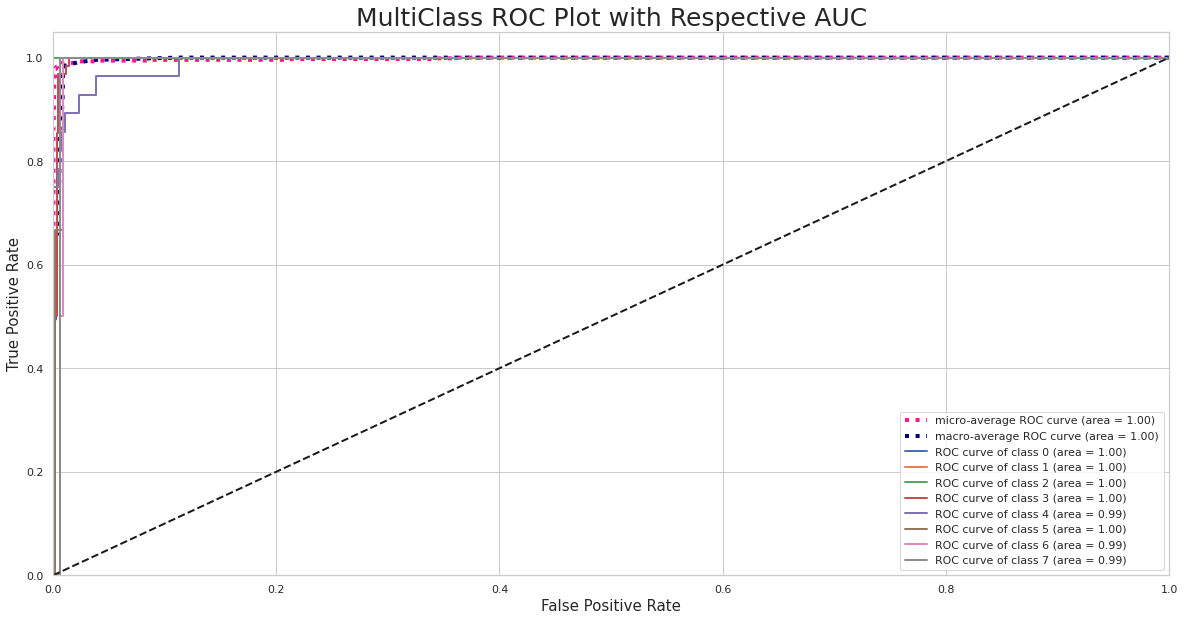

In [ ]:
def plot_multiclass_roc(Y_Test, Predictions):
  # Compute ROC curve and Area Under Curve (AUC) for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(class_number):
      fpr[i], tpr[i], _ = roc_curve(Y_Test[:, i], Predictions[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(Y_Test.ravel(), Predictions.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(class_number)]))
  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(class_number):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= class_number

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(figsize=(20, 10))
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  for i in range(class_number):
      plt.plot(fpr[i], tpr[i], lw=2,
              label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate', fontsize=15)
  plt.ylabel('True Positive Rate', fontsize=15)
  plt.title('MultiClass ROC Plot with Respective AUC', fontsize=25)
  plt.legend(loc="lower right")
  plt.show()
#
plot_multiclass_roc(Y_Test, Predictions)

Average precision score, micro-averaged over all classes: 0.99


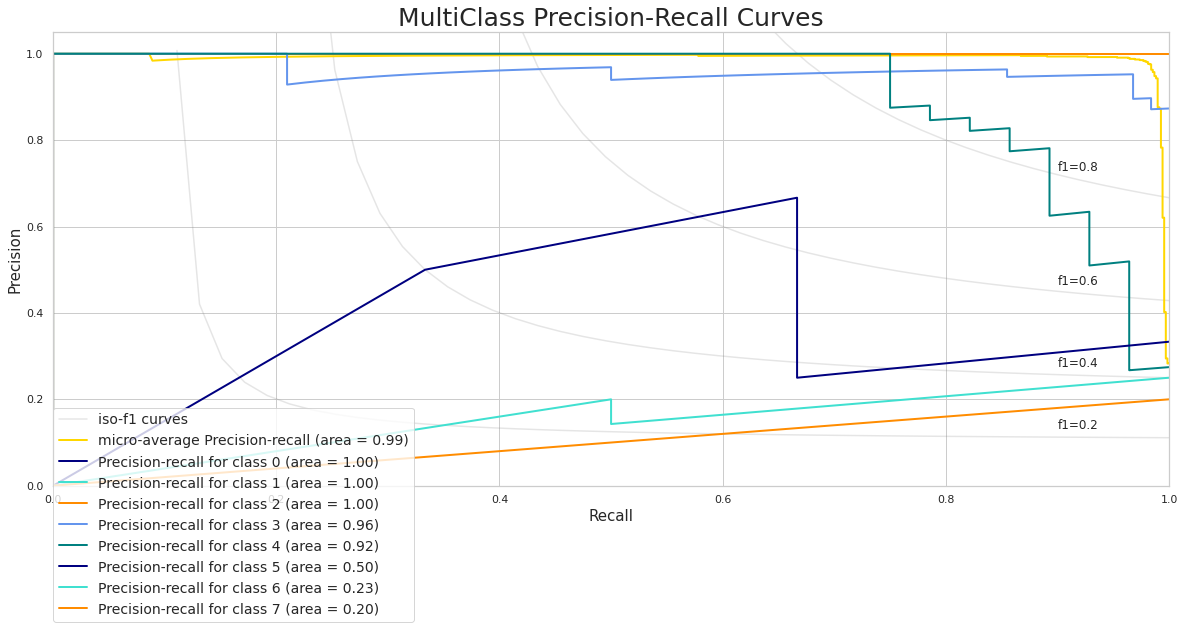

In [ ]:
def plot_multiclass_precision_recall_curves(Y_Test, Predictions):
  # For each class
  precision = dict()
  recall = dict()
  average_precision = dict()
  for i in range(class_number):
      precision[i], recall[i], _ = precision_recall_curve(Y_Test[:, i], Predictions[:, i])
      average_precision[i] = average_precision_score(Y_Test[:, i], Predictions[:, i])

  # A "micro-average": quantifying score on all classes jointly
  precision["micro"], recall["micro"], _ = precision_recall_curve(Y_Test.ravel(), Predictions.ravel())
  average_precision["micro"] = average_precision_score(Y_Test, Predictions, average="micro")
  print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))

  from itertools import cycle
  # setup plot details
  colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

  plt.figure(figsize=(20, 10))
  f_scores = np.linspace(0.2, 0.8, num=4)
  lines = []
  labels = []
  for f_score in f_scores:
      x = np.linspace(0.01, 1)
      y = f_score * x / (2 * x - f_score)
      l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
      plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

  lines.append(l)
  labels.append('iso-f1 curves')
  l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
  lines.append(l)
  labels.append('micro-average Precision-recall (area = {0:0.2f})'''.format(average_precision["micro"]))

  for i, color in zip(range(class_number), colors):
      l, = plt.plot(recall[i], precision[i], color=color, lw=2)
      lines.append(l)
      labels.append('Precision-recall for class {0} (area = {1:0.2f})'''.format(i, average_precision[i]))

  fig = plt.gcf()
  fig.subplots_adjust(bottom=0.25)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Recall', fontsize=15)
  plt.ylabel('Precision', fontsize=15)
  plt.title('MultiClass Precision-Recall Curves', fontsize=25)
  plt.legend(lines, labels, loc=(0, -.3), prop=dict(size=14))
  plt.show()
#
plot_multiclass_precision_recall_curves(Y_Test, Predictions)